<a href="https://colab.research.google.com/github/Andrian0s/ML4NLP1-2024-Tutorial-Notebooks/blob/main/tutorials_notebooks_in_class_2024/w11_picoGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is an adaptation of [Jay Mody's blog post on picoGPT](https://jaykmody.com/blog/gpt-from-scratch/).

The goal of this notebook is to demonstrate how GPT works with minimal and basic numpy code.


Note, as a complement to this resource, we recommend reading the [Illustrated GPT blog by Jay Alammar](https://jalammar.github.io/illustrated-gpt2/), which provides a very nice and visual description of the internal processes.




In [1]:
%%capture
!git clone https://github.com/jaymody/picoGPT.git

In [2]:
%%capture
!pip install -r 'picoGPT/requirements.txt'

In [3]:
!pip install icecream

In [4]:
# test the commandline call to make sure installation worked
# !python picoGPT/gpt2.py "Alan Turing theorized that computers would one day become"

In [5]:
# imports
import sys
import numpy as np
from tqdm import tqdm
from icecream import ic

# Add the picoGPT directory to sys.path in order to import helpers
if not '/content/picoGPT' in sys.path:
    sys.path.append('/content/picoGPT')
    print(sys.path)

from utils import load_encoder_hparams_and_params


['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/picoGPT']


/usr/local/lib/python3.10/dist-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.20) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


# Predicting the next token and computing the loss for the sequence:

`Not all heroes wear capes`

In [8]:
vocab = ['not', 'all', 'heroes', 'wear', 'capes'] # 5 items in our vocabulary

def dummy_gpt(x: np.array, stochastic: bool =False):
    """
    A 'dummy' GPT. Takes an input x sequence and outputs a matrix with next token prediction probabilities for a given vocab.

    Args:
        x: input numpy array
        stochastic: if True, the output matrix is randomly generated.
    Returns:
        output matrix contains all the predicted next token probability distributions at each position and has shape [num_tokens_in_input_seq - 1, num_tokens_in_vocab]
    """
    if stochastic:
        output = np.random.rand(len(x), len(vocab)) # random values
        output /= output.sum(axis=1, keepdims=True) # normalize to [0,1]
    else:
        output = np.array([
            [0.1, 0.4, 0.2, 0.1, 0.2], # Probabilities for predicting the next token after "not"
            [0.05, 0.1, 0.7, 0.1, 0.05], # Probabilities for predicting the next token after "all"
            [0.1, 0.1, 0.1, 0.6, 0.1], # Probabilities for predicting the next token after "heroes"
            [0.2, 0.2, 0.1, 0.1, 0.4], # Probabilities for predicting the next token after "wear"
        ])
    return output

inputs = np.array([0, 1, 2, 3, 4]) #
x = np.array([0, 1, 2, 3]) # [not, all, heroes, wear]
y = np.array([1, 2, 3, 4]) # [all, heroes, wear, capes]

ic([vocab[i] for i in inputs])
ic([vocab[i] for i in x])
ic([vocab[i] for i in y])

# What is the loss when the prediction probabilities are random?
output = dummy_gpt(x, stochastic=True)
ic(output)

o = output[np.arange(len(output)), y]
ic(o)

loss = np.mean(-np.log(o))
ic(loss)

ic| [vocab[i] for i in inputs]: ['not', 'all', 'heroes', 'wear', 'capes']
ic| [vocab[i] for i in x]: ['not', 'all', 'heroes', 'wear']
ic| [vocab[i] for i in y]: ['all', 'heroes', 'wear', 'capes']
ic| output: array([[0.05730092, 0.29125855, 0.38442879, 0.05596454, 0.2110472 ],
                   [0.12707577, 0.13135543, 0.20415093, 0.35553657, 0.1818813 ],
                   [0.07241317, 0.1042076 , 0.38438858, 0.11355035, 0.3254403 ],
                   [0.11457584, 0.18748023, 0.20604333, 0.21017845, 0.28172215]])
ic| o: array([0.29125855, 0.20415093, 0.11355035, 0.28172215])
ic| loss: 1.5661956314610228


1.5661956314610228

In [9]:
# Compare above with what happens when the prediction probabilities are closer to the ground truth:
output = dummy_gpt(x, stochastic=False)
ic(output)

o = output[np.arange(len(output)), y]
ic(o)

loss = np.mean(-np.log(o))
ic(loss)

ic| output: array([[0.1 , 0.4 , 0.2 , 0.1 , 0.2 ],
                   [0.05, 0.1 , 0.7 , 0.1 , 0.05],
                   [0.1 , 0.1 , 0.1 , 0.6 , 0.1 ],
                   [0.2 , 0.2 , 0.1 , 0.1 , 0.4 ]])
ic| o: array([0.4, 0.7, 0.6, 0.4])
ic| loss: 0.6750205078632583


0.6750205078632583

# Inspecting the tokenizer

In [10]:
# load tokenizer, hparams, and params from the released open-ai gpt-2 files
model_size: str = "124M"
models_dir: str = "models"
tokenizer, hparams, params = load_encoder_hparams_and_params(model_size, models_dir)

# set the number of tokens to generate
n_tokens_to_generate: int = 40

Fetching checkpoint: 1.00kb [00:00, 4.17Mb/s]                                                       
Fetching encoder.json: 1.04Mb [00:00, 2.93Mb/s]                                                     
Fetching hparams.json: 1.00kb [00:00, 1.26Mb/s]                                                     
Fetching model.ckpt.data-00000-of-00001: 498Mb [00:12, 38.9Mb/s]                                    
Fetching model.ckpt.index: 6.00kb [00:00, 13.1Mb/s]                                                 
Fetching model.ckpt.meta: 472kb [00:00, 1.73Mb/s]                                                   
Fetching vocab.bpe: 457kb [00:00, 1.94Mb/s]                                                         


In [11]:
prompt = "Not all heroes wear capes."
input_ids = tokenizer.encode(prompt)

print(f'\nToken IDs for the sequence `{prompt}`:\n')
print(input_ids)

print(f'\nTokens for the sequence `{prompt}`:\n')
print([tokenizer.decoder[i] for i in input_ids])

# make sure we are not surpassing the max sequence length of our model
assert len(input_ids) + n_tokens_to_generate < hparams["n_ctx"]


Token IDs for the sequence `Not all heroes wear capes.`:

[3673, 477, 10281, 5806, 1451, 274, 13]

Tokens for the sequence `Not all heroes wear capes.`:

['Not', 'Ġall', 'Ġheroes', 'Ġwear', 'Ġcap', 'es', '.']


> What is the significance of `Ġ`?


# Inspect model parameters

In [ ]:
# params is a nested json dictionary that holds the trained weights of our model. The leaf nodes of the json are NumPy arrays

# {
#     "wpe": [n_ctx, n_embd],
#     "wte": [n_vocab, n_embd],
#     "ln_f": {"b": [n_embd], "g": [n_embd]},
#     "blocks": [
#         {
#             "attn": {
#                 "c_attn": {"b": [3*n_embd], "w": [n_embd, 3*n_embd]},
#                 "c_proj": {"b": [n_embd], "w": [n_embd, n_embd]},
#             },
#             "ln_1": {"b": [n_embd], "g": [n_embd]},
#             "ln_2": {"b": [n_embd], "g": [n_embd]},
#             "mlp": {
#                 "c_fc": {"b": [4*n_embd], "w": [n_embd, 4*n_embd]},
#                 "c_proj": {"b": [n_embd], "w": [4*n_embd, n_embd]},
#             },
#         },
#         ... # repeat for n_layers
#     ]
# }

In [12]:
def shape_tree(d):
    """
    Helper function to print shapes of objects in a nested dictionary.
    """
    if isinstance(d, np.ndarray):
        return list(d.shape)
    elif isinstance(d, list):
        return [shape_tree(v) for v in d]
    elif isinstance(d, dict):
        return {k: shape_tree(v) for k, v in d.items()}
    else:
        ValueError("uh oh")

from pprint import pprint

pprint(type(params))
pprint(params.keys())
pprint(shape_tree(params))

<class 'dict'>
dict_keys(['blocks', 'ln_f', 'wpe', 'wte'])
{'blocks': [{'attn': {'c_attn': {'b': [2304], 'w': [768, 2304]},
                      'c_proj': {'b': [768], 'w': [768, 768]}},
             'ln_1': {'b': [768], 'g': [768]},
             'ln_2': {'b': [768], 'g': [768]},
             'mlp': {'c_fc': {'b': [3072], 'w': [768, 3072]},
                     'c_proj': {'b': [768], 'w': [3072, 768]}}},
            {'attn': {'c_attn': {'b': [2304], 'w': [768, 2304]},
                      'c_proj': {'b': [768], 'w': [768, 768]}},
             'ln_1': {'b': [768], 'g': [768]},
             'ln_2': {'b': [768], 'g': [768]},
             'mlp': {'c_fc': {'b': [3072], 'w': [768, 3072]},
                     'c_proj': {'b': [768], 'w': [3072, 768]}}},
            {'attn': {'c_attn': {'b': [2304], 'w': [768, 2304]},
                      'c_proj': {'b': [768], 'w': [768, 768]}},
             'ln_1': {'b': [768], 'g': [768]},
             'ln_2': {'b': [768], 'g': [768]},
             'mlp'



> What is the model's hidden dimension?

> How deep is the model (i.e. how many transformer blocks)?

> What is the maximum sequence length?

> How many tokens are in the vocabulary?

> How many params are in each block?

> How many params in total?

> Compare the attention mechanisms vs. feedforward layers vs. embedding layers. Where are the majority of the params?

In [26]:
def get_param_count(d):
    """
    Helper function to print the sum of parameters in a nested dictionary representing a model's parameters
    """
    total = 0

    if isinstance(d, np.ndarray):
        return np.prod(d.shape)

    elif isinstance(d, dict):
        for value in d.values():
            total += get_param_count(value)

    elif isinstance(d, (list, tuple)):
        for item in d:
            total += get_param_count(item)

    return total

total_c = get_param_count(params)
attn_param_c = sum([get_param_count(block['attn']) for block in params['blocks']])
ff_param_c = sum([get_param_count(block['mlp']) for block in params['blocks']])
emb_param_c = get_param_count(params['wte'])

print(f'Total params: {total_c}')
print(f'Attention params: {attn_param_c}, {attn_param_c/total_c*100:.2f}%')
print(f'Feedforward params: {ff_param_c}, {ff_param_c/total_c*100:.2f}%')
print(f'Embedding params: {emb_param_c}, {emb_param_c/total_c*100:.2f}%')


Total params: 124439808
Attention params: 28348416, 22.78%
Feedforward params: 56669184, 45.54%
Embedding params: 38597376, 31.02%


# Inspect hyperparameters (hparams)

In [27]:
hparams

{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}

# Let's code GPT-2

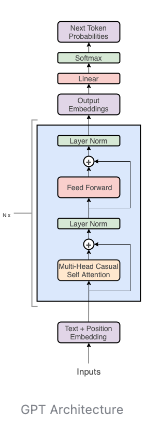

In [32]:
def gelu(x):
    """
    Activation function used in GPT2

    Args:
        x: input array
    Returns:
        array after applying the gelu activation function
    """
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))


def softmax(x):
    """
    Softmax is used to a convert set of real numbers (between -inf and inf) to probabilities (between 0 and 1, with the numbers all summing to 1)

    Args:
        x: input array
    Returns:
        array of probabilities
    """
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)


def layer_norm(x, g, b, eps: float = 1e-5):
    """
    layernorm standardizes values to have a mean of 0 and a variance of 1
    it ensures that the inputs for each layer are always within a consistent range, which is supposed to speed up and stabilize the training process
    layer normalization over the last axis of the input.

    Args:
        x: input
        g: gamma, corresponds to `g` in ln_1 and ln_2
        b: beta, corresponds to `b` in ln_1 and ln_2
        eps: epsilon, hyperparameter used to prevent division by zero
    Returns:
        normalised and rescaled x
    """
    mean = np.mean(x, axis=-1, keepdims=True)
    variance = np.var(x, axis=-1, keepdims=True)
    x = (x - mean) / np.sqrt(variance + eps)  # normalize x to have mean=0 and var=1 over last axis
    return g * x + b  # scale and offset with gamma/beta params


def linear(x, w, b):  # [m, in], [in, out], [out] -> [m, out]
    """
    Standard matrix multiplication + bias

    Args:
        x: input array [m, in]
        w: weight matrix [in, out]
        b: bias vector [out]
    Returns:
        output array [m, out]
    """
    # the @ operator is syntactic sugar for np.matmul()
    return x @ w + b


def ffn(x, c_fc, c_proj):
    """
    A simple multi-layer perceptron with 2 layers that projects from n_embd up to a higher dimension 4*n_embd and then back down to n_embd.

    Args:
        x: input array [n_seq, n_embd]
        c_fc: weight matrix for the first layer (projects up) [n_embd, 4*n_embd]
        c_proj: weight matrix for the second layer (projects down) [4*n_embd, n_embd]
    Returns:
        output array [n_seq, n_embd]
    """
    # project up
    a = gelu(linear(x, **c_fc))  # [n_seq, n_embd] -> [n_seq, 4*n_embd]

    # project back down
    x = linear(a, **c_proj)  # [n_seq, 4*n_embd] -> [n_seq, n_embd]

    return x


def attention(q, k, v, mask):
    """
    Computes masked attention given q,k,v matrices

    Args:
        q: query matrix [n_q, d_k]
        k: key matrix [n_k, d_k]
        v: value matrix [n_k, d_v]
        mask: mask matrix [n_q, n_k]
    Returns:
        output array [n_q, d_v]
    """

    # print(f'q: {q.shape}, k: {k.shape}, v: {v.shape}')

    output = softmax(q @ k.T / np.sqrt(q.shape[-1]) + mask) @ v

    return output


def mha(x, c_attn, c_proj, n_head):  # [n_seq, n_embd] -> [n_seq, n_embd]
    """
    Multi-head attention

    Args:
        x: input array [n_seq, n_embd]
        c_attn: weight matrix for the attention projection to get q,k,v
        c_proj: weight matrix for the projection
        n_head: number of heads (usually 12)
    Returns:
        output array [n_seq, n_embd]
    """
    # qkv projection
    x = linear(x, **c_attn)  # [n_seq, n_embd] -> [n_seq, 3*n_embd]

    # split into qkv
    qkv = np.split(x, 3, axis=-1)  # [n_seq, 3*n_embd] -> [3, n_seq, n_embd]

    # split into heads
    qkv_heads = list(map(lambda x: np.split(x, n_head, axis=-1), qkv))  # [3, n_seq, n_embd] -> [3, n_head, n_seq, n_embd/n_head]

    # causal mask to hide future inputs from being attended to
    causal_mask = (1 - np.tri(x.shape[0], dtype=x.dtype)) * -1e10  # [n_seq, n_seq]

    # optional, step through the code to inspect intermediary results
    # breakpoint()

    # perform attention over each head
    out_heads = [attention(q, k, v, causal_mask) for q, k, v in zip(*qkv_heads)]  # [3, n_head, n_seq, n_embd/n_head] -> [n_head, n_seq, n_embd/n_head]

    # merge heads
    x = np.hstack(out_heads)  # [n_head, n_seq, n_embd/n_head] -> [n_seq, n_embd]

    # out projection
    x = linear(x, **c_proj)  # [n_seq, n_embd] -> [n_seq, n_embd]

    return x


def transformer_block(x, mlp, attn, ln_1, ln_2, n_head): # [n_seq, n_embd] -> [n_seq, n_embd]
    """
    Transformer block with multi-head attention and feed-forward network

    Args:
        x: input array [n_seq, n_embd]
        mlp: weight matrices for the feed-forward network
        attn: weight matrices for the multi-head attention
        ln_1: weight matrices for the first layer normalization
        ln_2: weight matrices for the second layer normalization
        n_head: number of heads (usually 12)
    Returns:
        output array [n_seq, n_embd]
    """
    # multi-head causal self attention
    x = x + mha(layer_norm(x, **ln_1), **attn, n_head=n_head)  # [n_seq, n_embd] -> [n_seq, n_embd]

    # position-wise feed forward network
    x = x + ffn(layer_norm(x, **ln_2), **mlp)  # [n_seq, n_embd] -> [n_seq, n_embd]

    return x


def gpt2(inputs, wte, wpe, blocks, ln_f, n_head): # [n_seq] -> [n_seq, n_vocab]
    """
    The real GPT function!

    Args:
        inputs: input sequence [n_seq]
        wte: token embedding matrix
        wpe: positional embedding matrix
        blocks: list of transformer blocks
        ln_f: weight matrices for the final layer normalization
        n_head: number of heads (usually 12)
    Returns:
        output array [n_seq, n_vocab]
    """

    # token + positional embeddings
    x = wte[inputs] + wpe[range(len(inputs))]  # [n_seq] -> [n_seq, n_embd]

    # forward pass through n_layer transformer blocks
    for block in blocks:
        x = transformer_block(x, **block, n_head=n_head)  # [n_seq, n_embd] -> [n_seq, n_embd]

    # final layer normalization before projection (special in GPT-2)
    x = layer_norm(x, **ln_f)  # [n_seq, n_embd] -> [n_seq, n_embd]

    # projection to vocab (note, we are reusing the embedding matrix wte)
    logits = x @ wte.T  # [n_seq, n_embd] -> [n_seq, n_vocab]

    return logits


def generate(inputs, params, n_head, n_tokens_to_generate):
    """
    Autorgressive generation function

    Args:
        inputs: input sequence [n_seq]
        params: model parameters
        n_head: number of heads (usually 12)
        n_tokens_to_generate: number of tokens to generate
    """

    for _ in tqdm(range(n_tokens_to_generate), "generating"):  # auto-regressive decode loop
        logits = gpt2(inputs, **params, n_head=n_head)  # model forward pass

        next_id = np.argmax(logits[-1]) # Note, there is no softmax happening here. Why not?

        inputs.append(int(next_id))  # append prediction to input. Why?

    return inputs[len(inputs) - n_tokens_to_generate :]  # only return generated ids

# let's generate!
prompt = "Not all heroes wear capes."
input_ids = tokenizer.encode(prompt)

n_tokens_to_generate: int = 40

# make sure we are not surpassing the max sequence length of our model
assert len(input_ids) + n_tokens_to_generate < hparams["n_ctx"]

# generate output ids
output_ids = generate(input_ids, params, hparams["n_head"], n_tokens_to_generate)

# decode the ids back into a string
output_text = tokenizer.decode(output_ids)

print('\n\nGenerated sequence:\n')
print(output_text)

generating: 100%|██████████| 40/40 [00:20<00:00,  1.96it/s]



Generated sequence:

 Some are more than just a costume.

The most common costume is a cape. It's a piece of clothing that's worn by heroes and villains. It's usually a cape that's worn




> In `generate()`, we append the `next_id` to the input sequence rather than cronstructing a new `output` variable to return. Why?

> Why do we not need `softmax` in this `generate` function?





# Inspecting the causal mask

Let's unpack the line:

`causal_mask = (1 - np.tri(x.shape[0], dtype=x.dtype)) * -1e10`


In [ ]:
# Step 1: initialise a diagonal array where lower triangle is filled with ones and zero elsewhere
m = np.tri(x.shape[0], dtype=x.dtype)
print(f'Step 1:\n{m}')
# Step 2: invert so lower triangle is filled with zeros and ones elsewhere
m = (1 - m)
# Step 3: multiply by -inf to mask indices corresponding to future tokens
print(f'Step 2:\n{m}')
m = m * -1e10
print(f'Step 3:\n{m}')

# Note, -1e10 = -10000000000.0 approximates -inf after softmax

Step 1:
[[1 0 0 0]
 [1 1 0 0]
 [1 1 1 0]
 [1 1 1 1]]
Step 2:
[[0 1 1 1]
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 0]]
Step 3:
[[-0.e+00 -1.e+10 -1.e+10 -1.e+10]
 [-0.e+00 -0.e+00 -1.e+10 -1.e+10]
 [-0.e+00 -0.e+00 -0.e+00 -1.e+10]
 [-0.e+00 -0.e+00 -0.e+00 -0.e+00]]


# Inspect attention

Let's unpack the line:

`softmax(q @ k.T / np.sqrt(q.shape[-1]) + mask) @ v`

In [33]:
# Let's unpack the line: softmax(q @ k.T / np.sqrt(q.shape[-1]) + mask) @ v

n_seq = 6
n_q = 4 # should match mask dim
d_k = 4
n_k = 4
d_v = 4

causal_mask = (1 - np.tri(d_k, dtype=x.dtype)) * -1e10

q = np.random.rand(n_q, d_k) # query matrix [n_q, d_k]
k = np.random.rand(n_k, d_k) # key matrix [n_k, d_k]
v = np.random.rand(n_k, d_v) # value matrix [n_k, d_v]

# Step 1: matmul queries and keys and normalise
x1 = q @ k.T / np.sqrt(q.shape[-1])
print(f'Step 1:\n{x1}')
# Step 2: add the mask
x2 = x1 + causal_mask
print(f'Step 2:\n{x2}')
# Step 3: apply softmax to get attention probabilities
x3 = softmax(x2)
print(f'Step 3:\n{x3}')
# Step 4:
x4 = x3 @ v
print(f'Step 4:\n{x4}')

Step 1:
[[0.44666548 0.61499874 0.40830254 0.67861022]
 [0.33612781 0.39504547 0.34757893 0.58094492]
 [0.44320921 0.66443669 0.50482814 0.76117033]
 [0.34044291 0.42213636 0.16288176 0.47244036]]
Step 2:
[[ 4.46665476e-01 -1.00000000e+10 -1.00000000e+10 -1.00000000e+10]
 [ 3.36127812e-01  3.95045473e-01 -1.00000000e+10 -1.00000000e+10]
 [ 4.43209208e-01  6.64436690e-01  5.04828141e-01 -1.00000000e+10]
 [ 3.40442915e-01  4.22136362e-01  1.62881763e-01  4.72440360e-01]]
Step 3:
[[1.         0.         0.         0.        ]
 [0.48527484 0.51472516 0.         0.        ]
 [0.30200858 0.37678808 0.32120334 0.        ]
 [0.24609095 0.26703898 0.20605436 0.28081571]]
Step 4:
[[0.68544703 0.89770099 0.92227513 0.99531652]
 [0.64687409 0.68596656 0.52237634 0.57305228]
 [0.45449605 0.62522667 0.62950249 0.66102742]
 [0.60486206 0.58845478 0.49411125 0.75382843]]


In [34]:
# inspect gelu
x = np.array([[1, 2], [-2, 0.5], [3, 0.1]])
print(x)
print(x.shape)
print(gelu(x))
print(gelu(x).shape)

[[ 1.   2. ]
 [-2.   0.5]
 [ 3.   0.1]]
(3, 2)
[[ 0.84119199  1.95459769]
 [-0.04540231  0.34571401]
 [ 2.99636261  0.05398275]]
(3, 2)


In [35]:
# inspect softmax
x = np.array([[1, 2], [-2, 0.5], [3, 0.1]])
print(x)
print(x.shape)
print(softmax(x))
print(softmax(x).shape)

[[ 1.   2. ]
 [-2.   0.5]
 [ 3.   0.1]]
(3, 2)
[[0.26894142 0.73105858]
 [0.07585818 0.92414182]
 [0.94784644 0.05215356]]
(3, 2)


# Going beyond greedy decoding

In [40]:
def generate(inputs, params, n_head, n_tokens_to_generate, do_sample=False, top_k=0):

    for _ in tqdm(range(n_tokens_to_generate), "generating"):  # auto-regressive decode loop
        logits = gpt2(inputs, **params, n_head=n_head)  # model forward pass

        if not do_sample:
            # greedy sampling
            next_id = np.argmax(logits[-1]) # Note, there is no softmax happening here. Why not?

        else:
            probs = softmax(logits[-1])

            if top_k > 0:
                # truncate probs
                probs[probs < np.sort(probs)[-top_k]] = 0
                probs = probs / np.sum(probs)

            next_id = np.random.choice(len(probs), p=probs)

        inputs.append(int(next_id))  # append prediction to input

    return inputs[len(inputs) - n_tokens_to_generate :]  # only return generated ids

# let's generate!
prompt = "Not all heroes wear capes."
input_ids = tokenizer.encode(prompt)

n_tokens_to_generate: int = 40

# make sure we are not surpassing the max sequence length of our model
assert len(input_ids) + n_tokens_to_generate < hparams["n_ctx"]

# generate output ids
output_ids = generate(input_ids, params, hparams["n_head"], n_tokens_to_generate, do_sample=True, top_k=10)

# decode the ids back into a string
output_text = tokenizer.decode(output_ids)

print('\n\nGenerated sequence:\n')
print(output_text)

generating: 100%|██████████| 40/40 [00:20<00:00,  1.95it/s]



Generated sequence:

 Some, like the Iron Maiden, are more popular, and some are not. But they all look the same, and that's what makes this game so exciting: You play the hero and he or




> What else could we do with the model's next-token scores?

> How could we avoid certain tokens tokens from being generated?

> How could we force the model to generate certain tokens?

